In [2]:
# Create data frames
import pandas as pd
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df_cleveland = pd.read_csv('data/cleveland.data', na_values='?', names=columns).drop_duplicates()
df_hungary = pd.read_csv('data/hungary.data', na_values='?', names=columns).drop_duplicates()
df_long_beach_va = pd.read_csv('data/long_beach_va.data', na_values='?', names=columns).drop_duplicates()
df_switzerland = pd.read_csv('data/switzerland.data', na_values='?', names=columns).drop_duplicates()

In [3]:
# Add origin column to each DataFrame
df_cleveland['origin'] = 'Cleveland'
df_hungary['origin'] = 'Hungary'
df_long_beach_va['origin'] = 'Long Beach VA'
df_switzerland['origin'] = 'Switzerland'

In [4]:
# Add target column
df_cleveland['target'] = (df_cleveland['num'] > 0).astype(int)
df_hungary['target'] = (df_hungary['num'] > 0).astype(int)
df_switzerland['target'] = (df_switzerland['num'] > 0).astype(int)
df_long_beach_va['target'] = (df_long_beach_va['num'] > 0).astype(int)

In [5]:
# Combine all DataFrames
df_combined = pd.concat([df_cleveland, df_hungary, df_switzerland, df_long_beach_va])

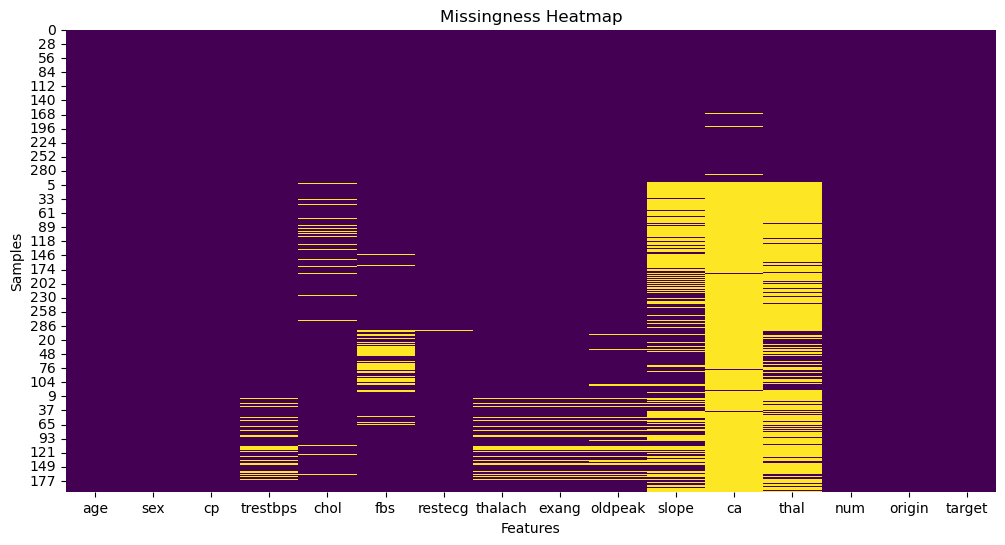

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Missingness Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_combined.isnull(), cbar=False, cmap='viridis')
plt.title('Missingness Heatmap')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

In [7]:
missing_counts_by_origin = df_combined.groupby("origin").apply(lambda g: g.isna().sum())

<positron-console-cell-7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


<positron-console-cell-8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



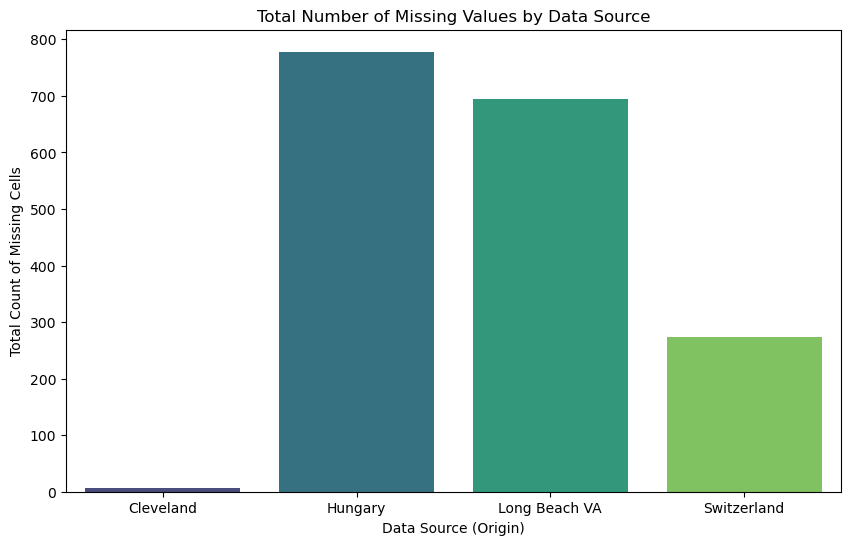

In [8]:
# --- Run this code in the next cell ---

# First, let's get the total number of missing values for each origin by summing across the columns (axis=1)
total_missing_by_origin = missing_counts_by_origin.sum(axis=1)

# Now, let's create a bar plot to visualize these totals
plt.figure(figsize=(10, 6))
sns.barplot(x=total_missing_by_origin.index, y=total_missing_by_origin.values, palette="viridis")
plt.title('Total Number of Missing Values by Data Source')
plt.xlabel('Data Source (Origin)')
plt.ylabel('Total Count of Missing Cells')
plt.show()

In [9]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

def simple_impute(df):
    df2 = df.copy()

    num_cols = df2.select_dtypes(include=[np.number]).columns
    cat_cols = df2.select_dtypes(exclude=[np.number]).columns

    if len(num_cols) > 0:
        num_imp = SimpleImputer(strategy="mean")
        df2[num_cols] = num_imp.fit_transform(df2[num_cols])

    if len(cat_cols) > 0:
        cat_imp = SimpleImputer(strategy="most_frequent")
        df2[cat_cols] = cat_imp.fit_transform(df2[cat_cols])

    return df2

df_cleveland_simple = simple_impute(df_cleveland)
df_hungary_simple = simple_impute(df_hungary)
df_switzerland_simple = simple_impute(df_switzerland)
df_long_beach_va_simple = simple_impute(df_long_beach_va)

df_combined_simple = pd.concat([df_cleveland_simple, df_hungary_simple, df_switzerland_simple, df_long_beach_va_simple])

In [10]:
from sklearn.impute import KNNImputer
import pandas as pd

def knn_impute(df, n_neighbors=5):
    df2 = df.copy()

    # Split columns
    num_cols = df2.select_dtypes(include=[np.number]).columns
    cat_cols = df2.select_dtypes(exclude=[np.number]).columns

    # KNN for numeric columns
    if len(num_cols) > 0:
        knn = KNNImputer(n_neighbors=n_neighbors, weights="uniform")
        df2[num_cols] = knn.fit_transform(df2[num_cols])

    # Most frequent for any non-numeric columns (if you ever have them)
    if len(cat_cols) > 0:
        cat_imp = SimpleImputer(strategy="most_frequent")
        df2[cat_cols] = cat_imp.fit_transform(df2[cat_cols])

    return df2

df_cleveland_knn = knn_impute(df_cleveland, n_neighbors=5)
df_hungary_knn = knn_impute(df_hungary, n_neighbors=5)
df_switzerland_knn = knn_impute(df_switzerland, n_neighbors=5)
df_long_beach_va_knn = knn_impute(df_long_beach_va, n_neighbors=5)

df_combined_knn = pd.concat([
    df_cleveland_knn,
    df_hungary_knn,
    df_switzerland_knn,
    df_long_beach_va_knn
])



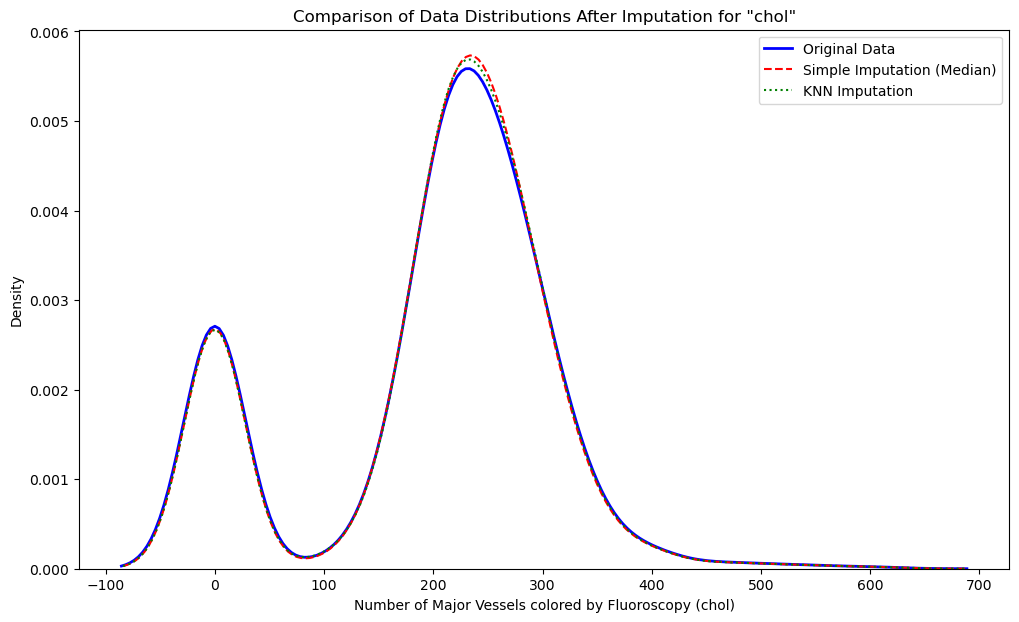

In [15]:
# Set up the plot
plt.figure(figsize=(12, 7))

# Plot the distribution of the original data (where it's not missing)
# We use a kernel density estimate (kde) plot, which is like a smooth histogram.
sns.kdeplot(df_combined['chol'].dropna(), label='Original Data', color='blue', linewidth=2)

# Plot the distribution of the data after Simple Imputation
sns.kdeplot(df_combined_simple['chol'], label='Simple Imputation (Median)', color='red', linestyle='--')

# Plot the distribution of the data after KNN Imputation
sns.kdeplot(df_combined_knn['chol'], label='KNN Imputation', color='green', linestyle=':')

# Add titles and labels for clarity
plt.title('Comparison of Data Distributions After Imputation for "chol"')
plt.xlabel('Number of Major Vessels colored by Fluoroscopy (chol)')
plt.ylabel('Density')
plt.legend()
plt.show()

<positron-console-cell-12>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



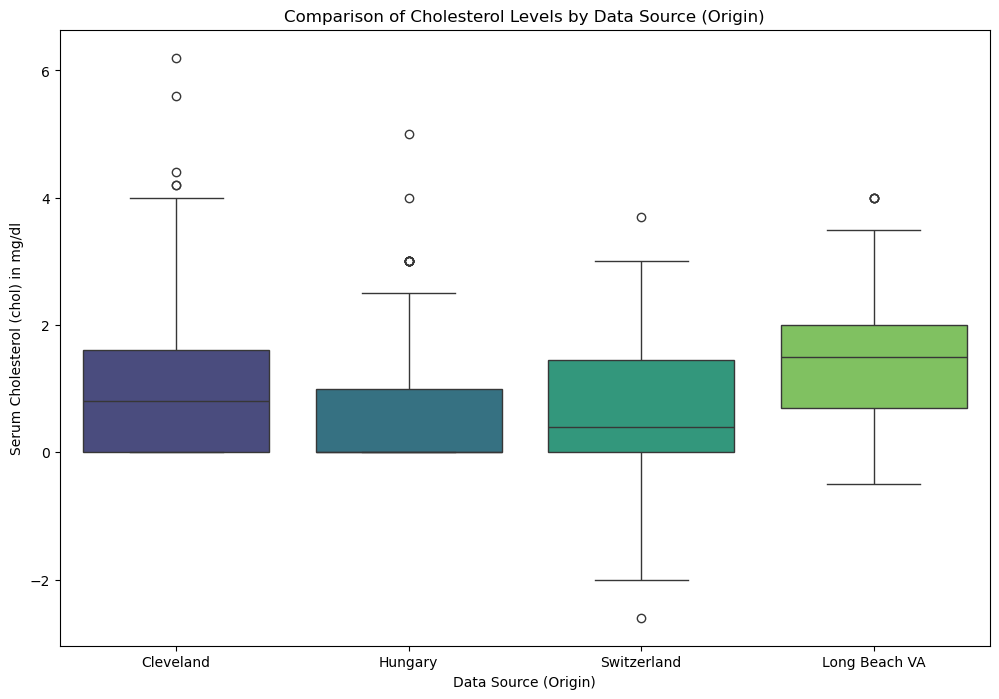

In [12]:
# --- Run this code in the next cell of your notebook ---

# Set up the plot with a larger size for clarity
plt.figure(figsize=(12, 8))

# Create a box plot using seaborn
# We will use your best dataset: df_combined_knn
sns.boxplot(data=df_combined_knn, x='origin', y='oldpeak', palette='viridis')

# Add titles and labels
plt.title('Comparison of Cholesterol Levels by Data Source (Origin)')
plt.xlabel('Data Source (Origin)')
plt.ylabel('Serum Cholesterol (chol) in mg/dl')
plt.show()

<positron-console-cell-13>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



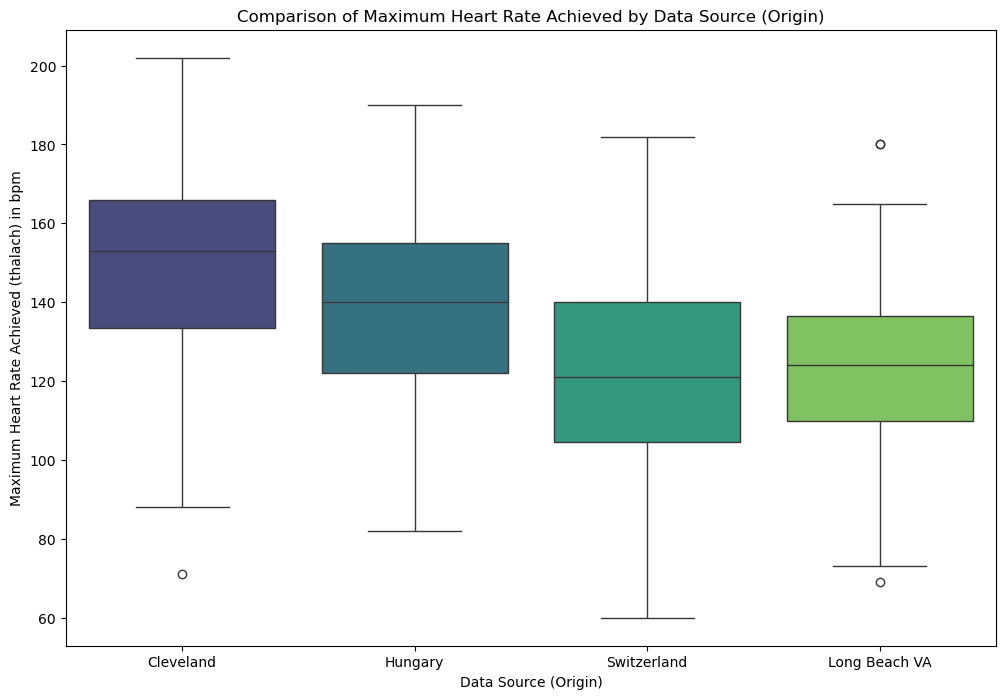

In [13]:
# --- Run this code in the next cell of your notebook ---

# Set up the plot with a larger size for clarity
plt.figure(figsize=(12, 8))

# Create a box plot for 'thalach' using your best dataset: df_combined_knn
sns.boxplot(data=df_combined_knn, x='origin', y='thalach', palette='viridis')

# Add titles and labels
plt.title('Comparison of Maximum Heart Rate Achieved by Data Source (Origin)')
plt.xlabel('Data Source (Origin)')
plt.ylabel('Maximum Heart Rate Achieved (thalach) in bpm')
plt.show()